In [62]:
from query_utils import SnowflakeEngine
import pandas as pd
import seaborn as sns
engine = SnowflakeEngine()
engine.connect()

In [63]:
query = """

WITH dates AS (
  SELECT
    date_started_at
  FROM
    ds_prod.model.dim_date
  WHERE
    date_started_at >= '2014-01-01'
    AND is_date_completed
),
base_table AS (
  SELECT
    d.date_started_at,
    experiment_group
  FROM
    dates AS d
    CROSS JOIN (
      VALUES
        ('control'),
        ('experiment')
    ) AS t(experiment_group)
),
cohorts AS (
  SELECT
    date_trunc('day', signed_up_at) AS signup_date,
    CASE
      WHEN is_in_crm_global_holdout THEN 'control'
      ELSE 'experiment'
    END AS experiment_group,
    count(1) users
  FROM
    ds_prod.model.dim_user
  WHERE
    is_in_crm_global_holdout IS NOT NULL
    AND NOT is_internal_user
  GROUP BY
    1,
    2
),
trials AS (
  SELECT
    trial_started_at,
    provider,
    brand_owning_user_id AS user_id,
    market
  FROM
    ds_prod.model.dim_subscription s
    LEFT JOIN dim_country c on s.country_code = c.country_code
  
  WHERE
    trial_started_at > '2019-01-01'
    AND plan_name = 'Canva Pro'
),
trialling_users AS (
  SELECT
    date_trunc('day', trial_started_at) AS trial_start_date,
    CASE
      WHEN is_in_crm_global_holdout THEN 'control'
      ELSE 'experiment'
    END AS experiment_group,
    market,
    count(
      CASE
        WHEN t.provider = 'internal' THEN 1
      END
    ) web_trialling_users,
    count(
      CASE
        WHEN t.provider = 'google' THEN 1
      END
    ) android_trialling_users,
    count(
      CASE
        WHEN t.provider = 'apple' THEN 1
      END
    ) ios_trialling_users,
    count(1) trialling_users
  FROM
    ds_prod.model.dim_user AS u
    JOIN trials AS t ON u.user_id = t.user_id
  WHERE
    u.is_in_crm_global_holdout IS NOT NULL
    AND NOT u.is_internal_user
  GROUP BY
    1,
    2,
    3
),
results AS (
  SELECT
    bt.date_started_at,
    bt.experiment_group,
    t.market,

    sum(coalesce(t.web_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) web_trial_rate_28d,
    sum(coalesce(t.web_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) web_trial_rate_7d,

    sum(coalesce(t.android_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) android_trial_rate_28d,
    sum(coalesce(t.android_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) android_trial_rate_7d,

    sum(coalesce(t.ios_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) ios_trial_rate_28d,
    sum(coalesce(t.ios_trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) ios_trial_rate_7d,

    sum(coalesce(t.trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) trial_rate_28d,
    sum(coalesce(t.trialling_users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group, market
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) trial_rate_7d,
    sum(coalesce(c.users, 0)) over (
      PARTITION by bt.experiment_group, market
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN unbounded preceding
        AND current ROW
    ) group_size
  FROM
    base_table bt
    LEFT JOIN cohorts c ON bt.date_started_at = c.signup_date
    AND bt.experiment_group = c.experiment_group
    LEFT JOIN trialling_users t ON bt.date_started_at = t.trial_start_date
    AND bt.experiment_group = t.experiment_group
)



SELECT
  date_started_at AS "Date",
  DENSE_RANK() OVER (
    ORDER BY
      date_started_at DESC
  ) AS "day_rank",
  market,
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Experiment Group Size",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN trial_rate_28d
    END
  ) "Control Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_28d
    END
  ) "Experiment Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN web_trial_rate_28d
    END
  ) "Control Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
    END
  ) "Experiment Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN android_trial_rate_28d
    END
  ) "Control Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
    END
  ) "Experiment Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN ios_trial_rate_28d
    END
  ) "Control iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
    END
  ) "Experiment iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN trial_rate_7d
    END
  ) "Control Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_7d
    END
  ) "Experiment Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN web_trial_rate_7d
    END
  ) "Control Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
    END
  ) "Experiment Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN android_trial_rate_7d
    END
  ) "Control Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
    END
  ) "Experiment Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN ios_trial_rate_7d
    END
  ) "Control iOS Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
    END
  ) "Experiment iOS Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift iOS Trial Rate - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Web Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Android Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift iOS Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Web Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Android Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift iOS Trials - 7d",
  0 AS "zero_line"
FROM
  results r
WHERE
  r.date_started_at >= '2019-01-01'
GROUP BY
  1,
  3
ORDER BY
  1 DESC

"""
df = engine.run_query(query)

In [64]:
df.head()

,date,day_rank,market,experiment group size,control trial rate - 28d,experiment trial rate - 28d,control web trial rate - 28d,experiment web trial rate - 28d,control android trial rate - 28d,experiment android trial rate - 28d,...,relative uplift ios trial rate - 7d,uplift trials - 28d,uplift web trials - 28d,uplift android trials - 28d,uplift ios trials - 28d,uplift trials - 7d,uplift web trials - 7d,uplift android trials - 7d,uplift ios trials - 7d,zero_line
0,2021-05-15,1,OSEA,242940396,0.000380,0.000398,0.000195,0.000187,0.000142,0.000164,...,0.125000000000,4372.927128,-1943.523168,5344.688712,728.821188,2915.284752,242.940396,2672.344356,242.940396,0
1,2021-05-15,1,LatinAmerica,242940396,0.000744,0.000753,0.000517,0.000514,0.000131,0.000138,...,0.050000000000,2186.463564,-728.821188,1700.582772,971.761584,242.940396,-242.940396,242.940396,242.940396,0
2,2021-05-15,1,Africa,242940396,0.000068,0.000068,0.000057,0.000056,0.000007,0.000007,...,None,0.000000,-242.940396,0.000000,0.000000,-242.940396,-242.940396,0.000000,0.000000,0
3,2021-05-15,1,None,265002454,0.000006,0.000001,0.000005,0.000001,0.000000,0.000000,...,None,-1325.012270,-1060.009816,0.000000,0.000000,-530.004908,-530.004908,0.000000,0.000000,0
4,2021-05-15,1,Asia,242940396,0.000173,0.000175,0.000135,0.000136,0.000013,0.000013,...,-0.142857142857,485.880792,242.940396,0.000000,242.940396,485.880792,485.880792,0.000000,-242.940396,0


In [65]:
df['date'] = pd.to_datetime(df['date'])

In [66]:
df.set_index('date',inplace=True)
df.sort_index(inplace=True)

In [77]:
df.head()

,day_rank,market,experiment group size,control trial rate - 28d,experiment trial rate - 28d,control web trial rate - 28d,experiment web trial rate - 28d,control android trial rate - 28d,experiment android trial rate - 28d,control ios trial rate - 28d,...,relative uplift ios trial rate - 7d,uplift trials - 28d,uplift web trials - 28d,uplift android trials - 28d,uplift ios trials - 28d,uplift trials - 7d,uplift web trials - 7d,uplift android trials - 7d,uplift ios trials - 7d,zero_line
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,866,Europe,113583,0.002358,0.002773,0.002358,0.002773,0.000000,0.000000,0.000000,...,None,47.136945,47.136945,0.000000,0.000000,47.136945,47.136945,0.000000,0.000000,0
2019-01-01,866,FiveEyes,113583,0.008927,0.010459,0.008927,0.010459,0.000000,0.000000,0.000000,...,None,174.009156,174.009156,0.000000,0.000000,174.009156,174.009156,0.000000,0.000000,0
2019-01-01,866,Africa,113583,0.000505,0.000414,0.000505,0.000414,0.000000,0.000000,0.000000,...,None,-10.336053,-10.336053,0.000000,0.000000,-10.336053,-10.336053,0.000000,0.000000,0
2019-01-01,866,OSEA,113583,0.001011,0.000916,0.001011,0.000916,0.000000,0.000000,0.000000,...,None,-10.790385,-10.790385,0.000000,0.000000,-10.790385,-10.790385,0.000000,0.000000,0
2019-01-01,866,Asia,113583,0.001011,0.000863,0.001011,0.000863,0.000000,0.000000,0.000000,...,None,-16.810284,-16.810284,0.000000,0.000000,-16.810284,-16.810284,0.000000,0.000000,0


In [78]:
df.columns

Index(['day_rank', 'market', 'experiment group size',
       'control trial rate - 28d', 'experiment trial rate - 28d',
       'control web trial rate - 28d', 'experiment web trial rate - 28d',
       'control android trial rate - 28d',
       'experiment android trial rate - 28d', 'control ios trial rate - 28d',
       'experiment ios trial rate - 28d', 'control trial rate - 7d',
       'experiment trial rate - 7d', 'control web trial rate - 7d',
       'experiment web trial rate - 7d', 'control android trial rate - 7d',
       'experiment android trial rate - 7d', 'control ios trial rate - 7d',
       'experiment ios trial rate - 7d', 'relative uplift trial rate - 28d',
       'relative uplift web trial rate - 28d',
       'relative uplift android trial rate - 28d',
       'relative uplift ios trial rate - 28d',
       'relative uplift trial rate - 7d',
       'relative uplift web trial rate - 7d',
       'relative uplift android trial rate - 7d',
       'relative uplift ios trial ra

In [79]:
df_web_relative = df[['market','relative uplift web trial rate - 28d']]

In [80]:
df_web_relative['Year'] = df_web_relative.index.year

<ipython-input-80-d41189fd5ce4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_relative['Year'] = df_web_relative.index.year


In [81]:
df_web_relative['day_of_year'] = df_web_relative.index.dayofyear

<ipython-input-81-b997f76cb06c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_relative['day_of_year'] = df_web_relative.index.dayofyear


In [82]:
df_web_relative.head()

,market,relative uplift web trial rate - 28d,Year,day_of_year
date,,,,
2019-01-01,Europe,0.175996607294,2019,1
2019-01-01,FiveEyes,0.171614204100,2019,1
2019-01-01,Africa,-0.180198019802,2019,1
2019-01-01,OSEA,-0.093966369931,2019,1
2019-01-01,Asia,-0.146389713155,2019,1


In [83]:
df_web_relative_2021 = df_web_relative.loc['2021']
df_web_relative_2021 = df_web_relative_2021[df_web_relative_2021['market'].notnull()]

In [84]:
df_web_relative_2021_pivot = df_web_relative_2021.pivot(columns = 'market', values = 'relative uplift web trial rate - 28d')

In [88]:
df_web_relative_2021_pivot = df_web_relative_2021_pivot.astype(float)
df_web_relative_2021_pivot['Zero Line'] = 0
df_web_relative_2021_pivot.head()

market,Africa,Asia,Europe,FiveEyes,LatinAmerica,MiddleEast,OSEA,Zero Line
date,,,,,,,,
2021-01-01,0.018868,-0.021277,0.025229,0.003115,0.003311,-0.027778,-0.022727,0
2021-01-02,0.018868,-0.028369,0.023041,0.001036,0.000000,-0.028169,-0.023077,0
2021-01-03,0.018868,-0.021429,0.025522,-0.002068,-0.006734,-0.028169,-0.030769,0
2021-01-04,0.000000,0.000000,0.020979,-0.006186,-0.013514,-0.014286,-0.031128,0
2021-01-05,-0.018182,-0.007246,0.018735,-0.011305,-0.016892,-0.014286,-0.027344,0


<AxesSubplot:title={'center':'Web Trial Rate Uplift by Market, Date'}, xlabel='Date [2021]', ylabel='Relative Web Trial Rate Uplift'>

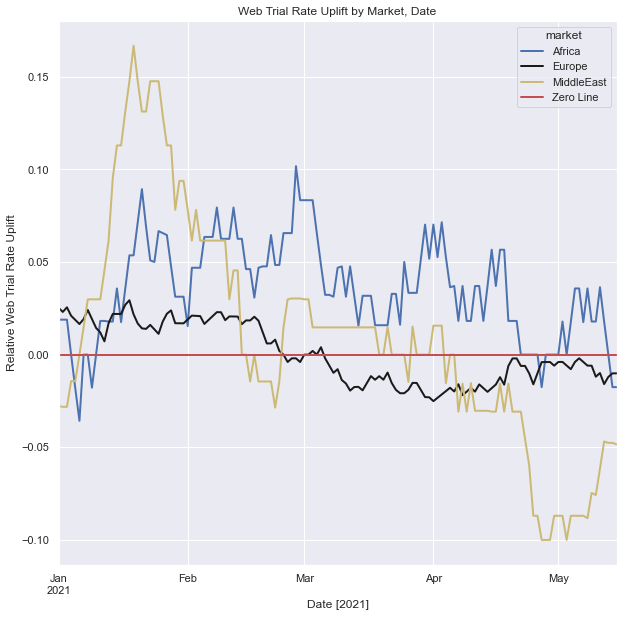

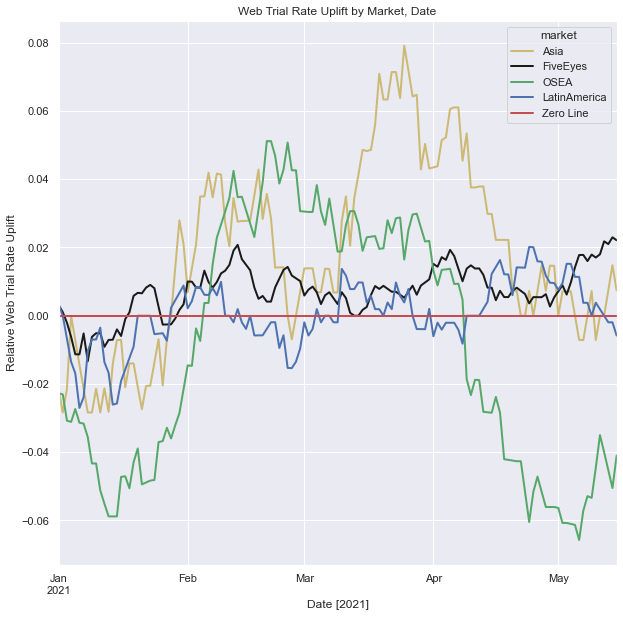

In [89]:
sns.set()

df_web_relative_2021_pivot[['Africa','Europe','MiddleEast', 'Zero Line']].plot(figsize=(10,10),color=['b','k','y','r'],lw=2,title="Web Trial Rate Uplift by Market, Date",ylabel = "Relative Web Trial Rate Uplift",xlabel="Date [2021]")
df_web_relative_2021_pivot[['Asia','FiveEyes','OSEA','LatinAmerica', 'Zero Line']].plot(figsize=(10,10),color=['y','k','g','b','r'],lw=2,title="Web Trial Rate Uplift by Market, Date",ylabel = "Relative Web Trial Rate Uplift",xlabel="Date [2021]")

<AxesSubplot:title={'center':'Relative Web Trial Rate Uplift by Calendar Year - Middle East'}, xlabel='Day Of Year', ylabel='Relative Web Trial Rate Uplift'>

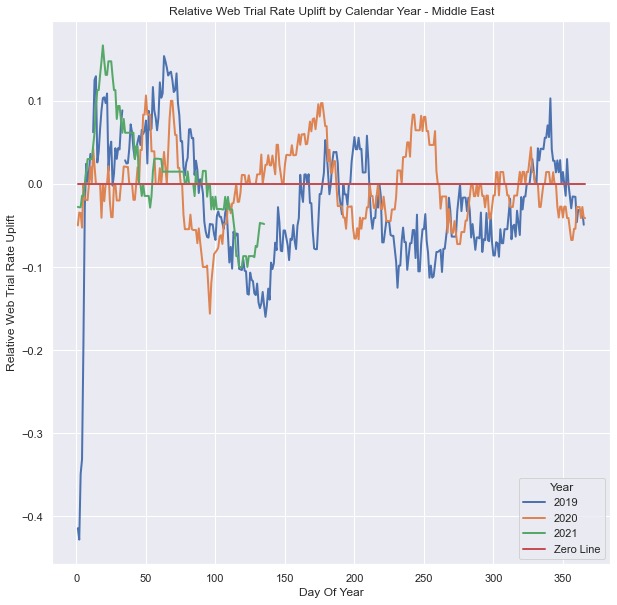

In [95]:
#year on year for middle east
df_web_relative_middleeast = df_web_relative.loc[df_web_relative['market'] == 'MiddleEast']
df_web_relative_middleeast_pivot= pd.pivot(df_web_relative_middleeast,index = 'day_of_year', columns = 'Year', values = 'relative uplift web trial rate - 28d')
df_web_relative_middleeast_pivot = df_web_relative_middleeast_pivot.astype(float)
df_web_relative_middleeast_pivot['Zero Line'] = 0
df_web_relative_middleeast_pivot.plot(figsize=(10,10),title="Relative Web Trial Rate Uplift by Calendar Year - Middle East",ylabel = "Relative Web Trial Rate Uplift",xlabel="Day Of Year", lw = 2)

<AxesSubplot:title={'center':'Relative Web Trial Rate Uplift by Calendar Year - OSEA'}, xlabel='Day Of Year', ylabel='Relative Web Trial Rate Uplift'>

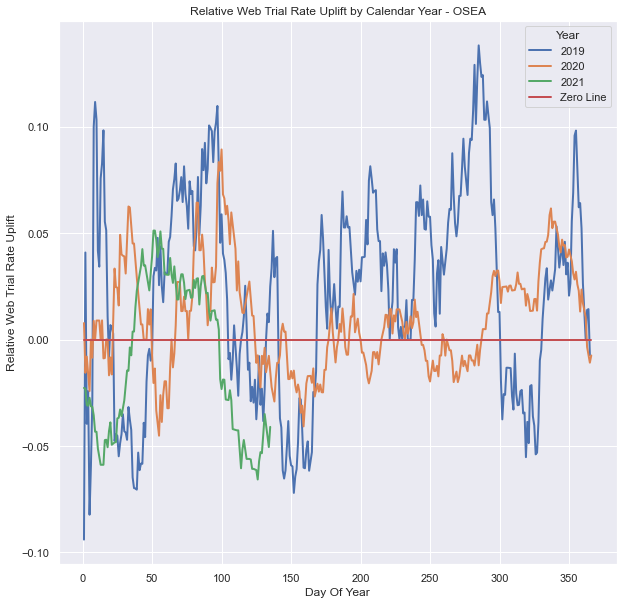

In [94]:
#year on year for OSEA
df_web_relative_OSEA = df_web_relative.loc[df_web_relative['market'] == 'OSEA']
df_web_relative_OSEA_pivot= pd.pivot(df_web_relative_OSEA,index = 'day_of_year', columns = 'Year', values = 'relative uplift web trial rate - 28d')
df_web_relative_OSEA_pivot = df_web_relative_OSEA_pivot.astype(float)
df_web_relative_OSEA_pivot['Zero Line'] = 0
df_web_relative_OSEA_pivot.plot(figsize=(10,10),title="Relative Web Trial Rate Uplift by Calendar Year - OSEA",ylabel = "Relative Web Trial Rate Uplift",xlabel="Day Of Year", lw=2)

<AxesSubplot:title={'center':'Relative Web Trial Rate Uplift by Calendar Year - Asia'}, xlabel='Day Of Year', ylabel='Relative Web Trial Rate Uplift'>

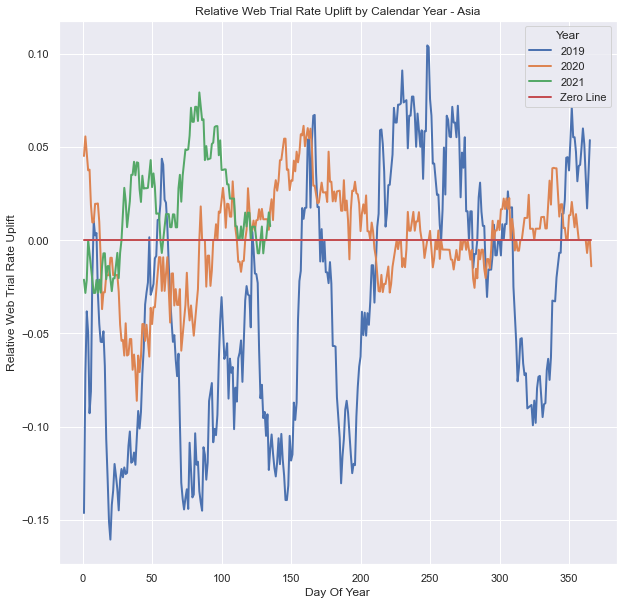

In [93]:
#year on year for Asia
df_web_relative_Asia = df_web_relative.loc[df_web_relative['market'] == 'Asia']
df_web_relative_Asia_pivot= pd.pivot(df_web_relative_Asia,index = 'day_of_year', columns = 'Year', values = 'relative uplift web trial rate - 28d')
df_web_relative_Asia_pivot = df_web_relative_Asia_pivot.astype(float)
df_web_relative_Asia_pivot['Zero Line'] = 0
df_web_relative_Asia_pivot.plot(figsize=(10,10),title="Relative Web Trial Rate Uplift by Calendar Year - Asia",ylabel = "Relative Web Trial Rate Uplift",xlabel="Day Of Year", lw=2)